In [5]:
!pip install dionysus
!pip install zarr
!pip install POT
!pip install gudhi
!pip install validclust

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dionysus: filename=dionysus-2.0.9-cp310-cp310-linux_x86_64.whl size=343749 sha256=df535d1272bed8e0910af2d7d9e5246810d3f9018fc11fd4ae72c6deb851f9cc
  Stored in directory: /root/.cache/pip/wheels/3c/ba/6a/813c63ae0687291480ca1b2d1b68ab4859aac4eafecf3d009d
Successfully built dionysus
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 53.0 MB/s eta 0:00:00
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5034 sha256=6d74b9cbde1439c7be1b08a7137708c37d8763d55cc2b1b3e26a67478eab71b1
  Stored in directory: /

In [3]:
from google.colab import drive
from google.colab import files
import os

drive.mount('/content/drive',force_remount=True)
#os.chdir("/content/drive/My Drive/NASA/Fire Detection/Data 6.5")
os.chdir("/content/drive/My Drive/Data 6.5")
!ls -ltr

Mounted at /content/drive
total 12815
-rw------- 1 root root 13118050 May  2 07:17 Fire_Labels_2020-2021.csv
drwx------ 2 root root     4096 May 30 04:41 Tiles_2021_2022


In [6]:
import zarr
import seaborn as sns
import numpy as np
import scipy
import pandas as pd
import dionysus as d
import matplotlib.pyplot as plt
import gudhi as gd
from gudhi.wasserstein import wasserstein_distance as wd
from gudhi.representations import Landscape
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, pairwise_distances
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from validclust import dunn, cop, ValidClust
from gudhi.wasserstein.barycenter import lagrangian_barycenter
import gudhi
sns.set_theme()

In [7]:
fname2 = 'Tiles_2021_2022'

rawFileList = os.listdir(fname2)
print (rawFileList)
print (len(rawFileList))

['Tile_1_33_20213570001178.zarr', 'Tile_1_33_20213600001178.zarr', 'Tile_1_33_20213640001178.zarr', 'Tile_1_33_20213630001178.zarr', 'Tile_1_33_20213550001178.zarr', 'Tile_1_33_20213610001178.zarr', 'Tile_1_33_20213620001178.zarr', 'Tile_1_33_20213590001178.zarr', 'Tile_1_33_20213560001178.zarr', 'Tile_1_33_20213580001178.zarr', 'Tile_1_33_20213540001178.zarr', 'Tile_1_33_20213450001177.zarr', 'Tile_1_33_20213470001177.zarr', 'Tile_1_33_20213460001177.zarr', 'Tile_1_33_20213480001178.zarr', 'Tile_1_33_20213490001178.zarr', 'Tile_1_33_20213520001178.zarr', 'Tile_1_33_20213510001178.zarr', 'Tile_1_33_20213500001178.zarr', 'Tile_1_33_20213530001178.zarr', 'Tile_1_33_20213400001177.zarr', 'Tile_1_33_20213410001177.zarr', 'Tile_1_33_20213440001177.zarr', 'Tile_1_33_20213350001177.zarr', 'Tile_1_33_20213420001177.zarr', 'Tile_1_33_20213390001177.zarr', 'Tile_1_33_20213430001177.zarr', 'Tile_1_33_20213380001177.zarr', 'Tile_1_33_20213360001177.zarr', 'Tile_1_33_20213370001177.zarr', 'Tile_1_3

In [8]:
csvName = 'Fire_Labels_2020-2021.csv'
dfLabel = pd.read_csv(csvName)[['fname', 'fire']]

label = dfLabel.loc[dfLabel['fname'] == 'Tile_1_33_20213600001178.zarr', 'fire'].iloc[0]
print (label)

0


In [9]:
print (len(rawFileList))

425


In [10]:
channel7List = []
channel7Name = []
timeSeriesDict = {}

for name in rawFileList:
    channelData = np.array(zarr.open(fname2 + '//' + name)[:, :, 0]) # select channel 7
    timeSeriesDict[name] = channelData
    channel7List.append(channelData)
    channel7Name.append(name)
    
print (len(channel7List))

#print (timeSeriesDict['Tile_1_33_20213600001178.zarr'])

425


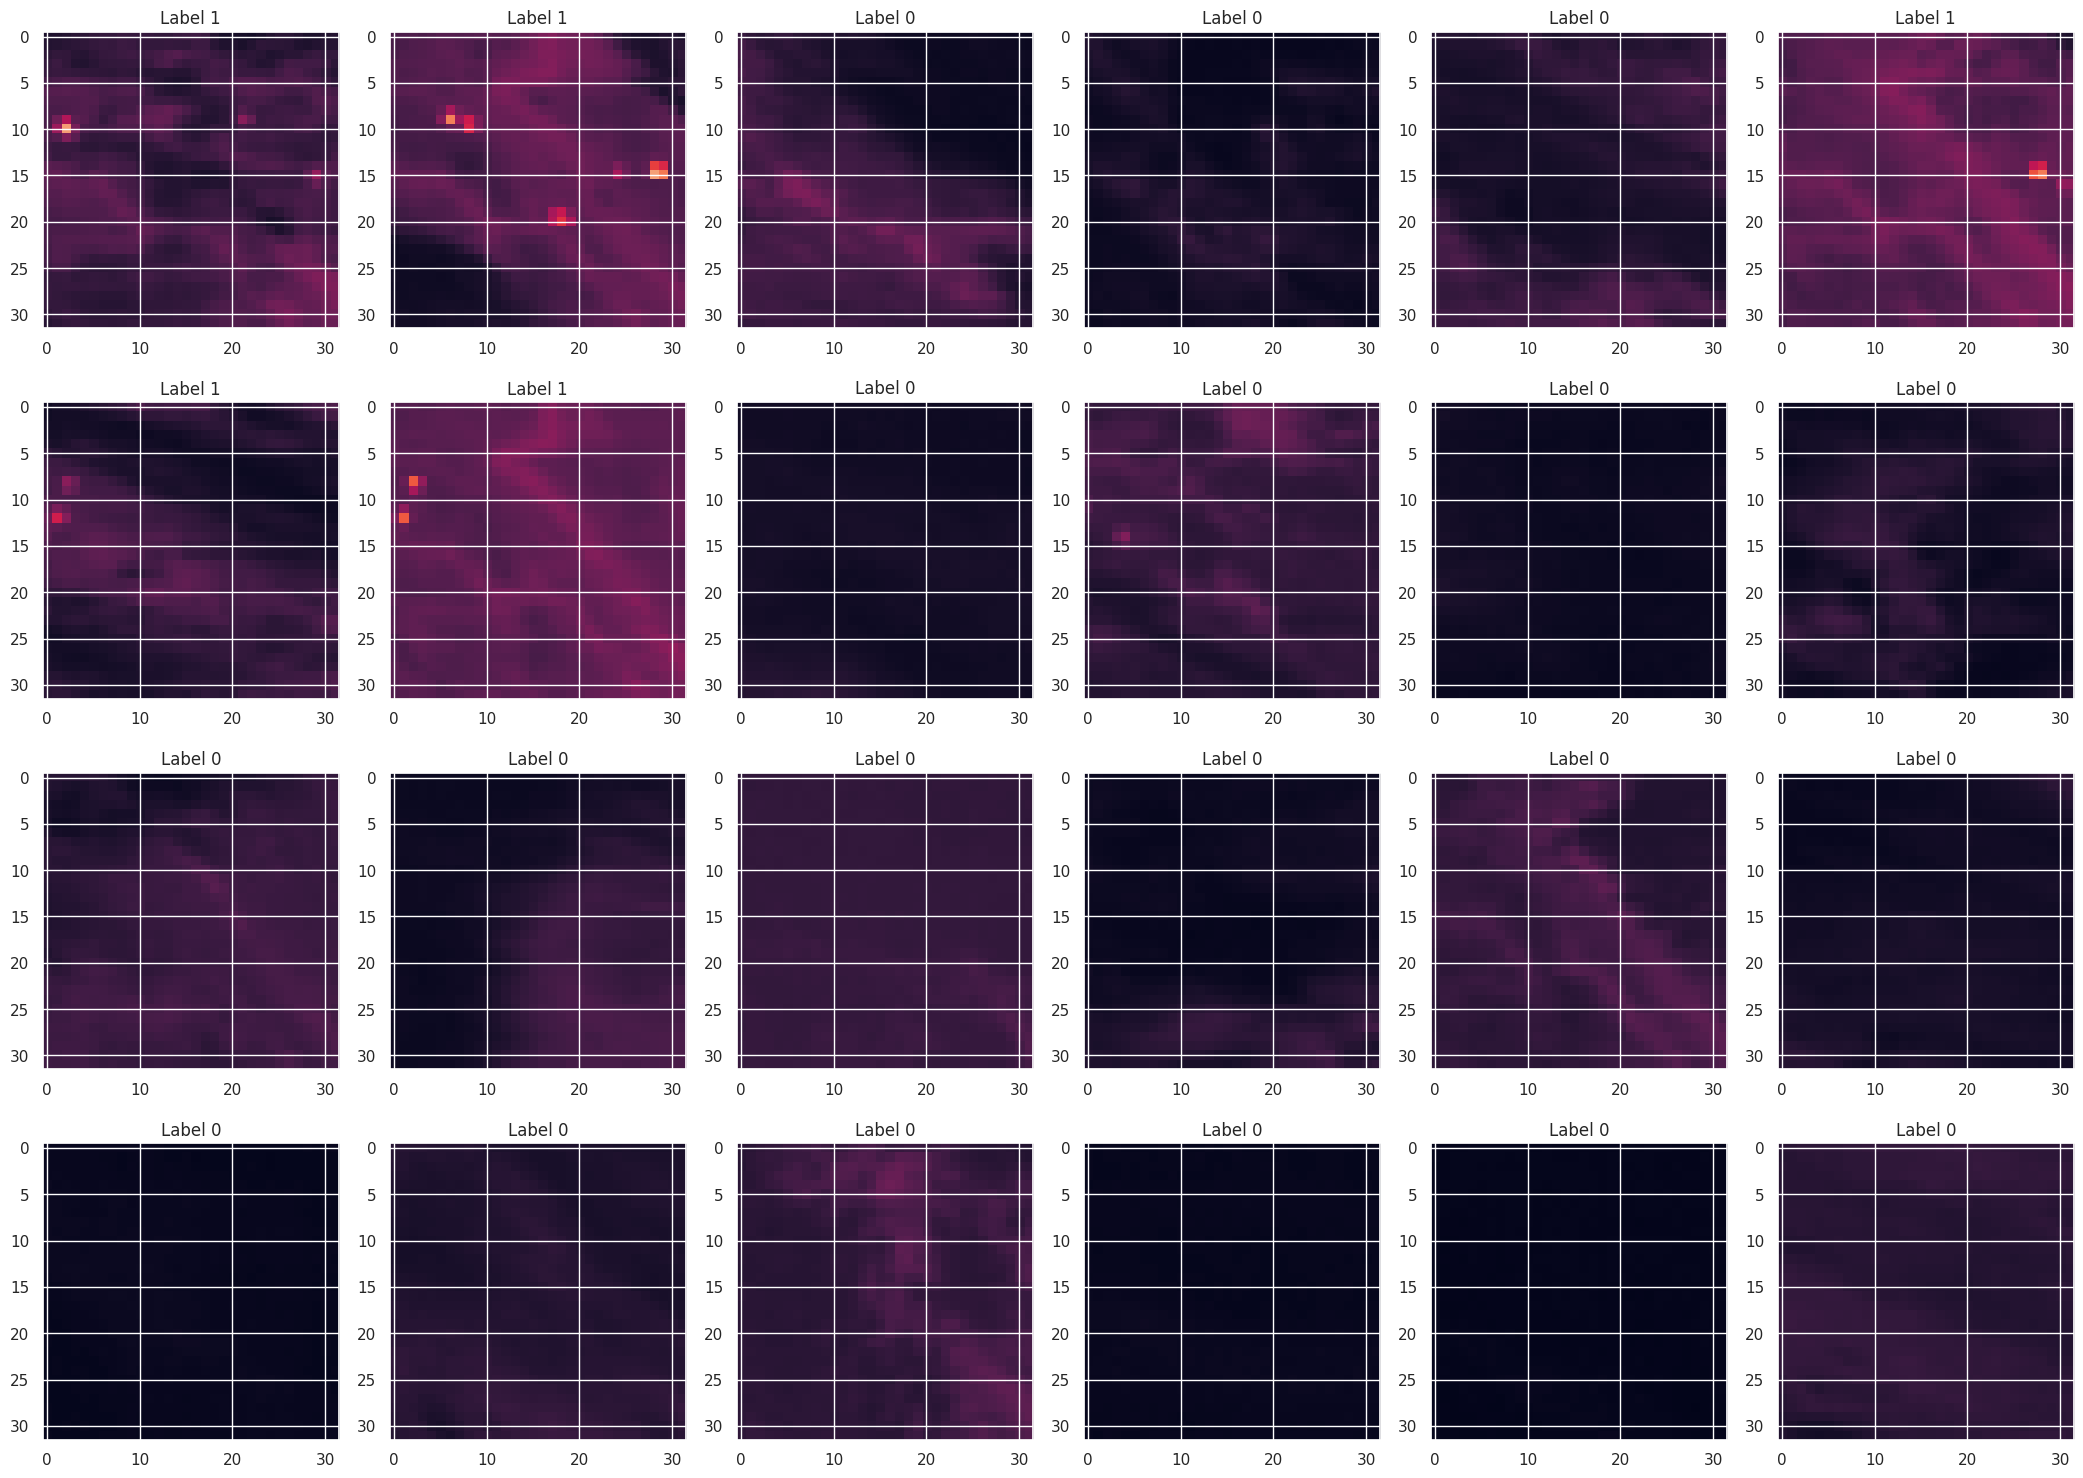

In [ ]:
# plot channel 7 timeseries
fig, axs = plt.subplots(4, 6, figsize=(21, 15))

for i in range(4):
    for j in range(6):
        axs[i, j].imshow(channel7List[i* 6 + j + 50], vmin=0, vmax=1) # vmin, vmax may change on different tiles
        label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j + 50], 'fire'].iloc[0]
        axs[i, j].title.set_text('Label {}'.format(label))

plt.tight_layout()

In [ ]:
def extract_PD_arrays_with_freudenthal_triangulation(data, lower_bound = 0, upper_bound = 8): #change upper bound!!!!!!!!!!
    
    f_lower_star = d.fill_freudenthal(np.array(data, dtype='float64'))
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    birth0=np.array([dgm.birth for dgm in dgms[0]])
    death0=np.array([dgm.death for dgm in dgms[0]])
    death0[death0==np.Infinity] = upper_bound 
    birth1=np.array([dgm.birth for dgm in dgms[1]])
    death1=np.array([dgm.death for dgm in dgms[1]])
    death1[death1==np.Infinity] = upper_bound
   
    return [[birth0,death0],[birth1,death1]]

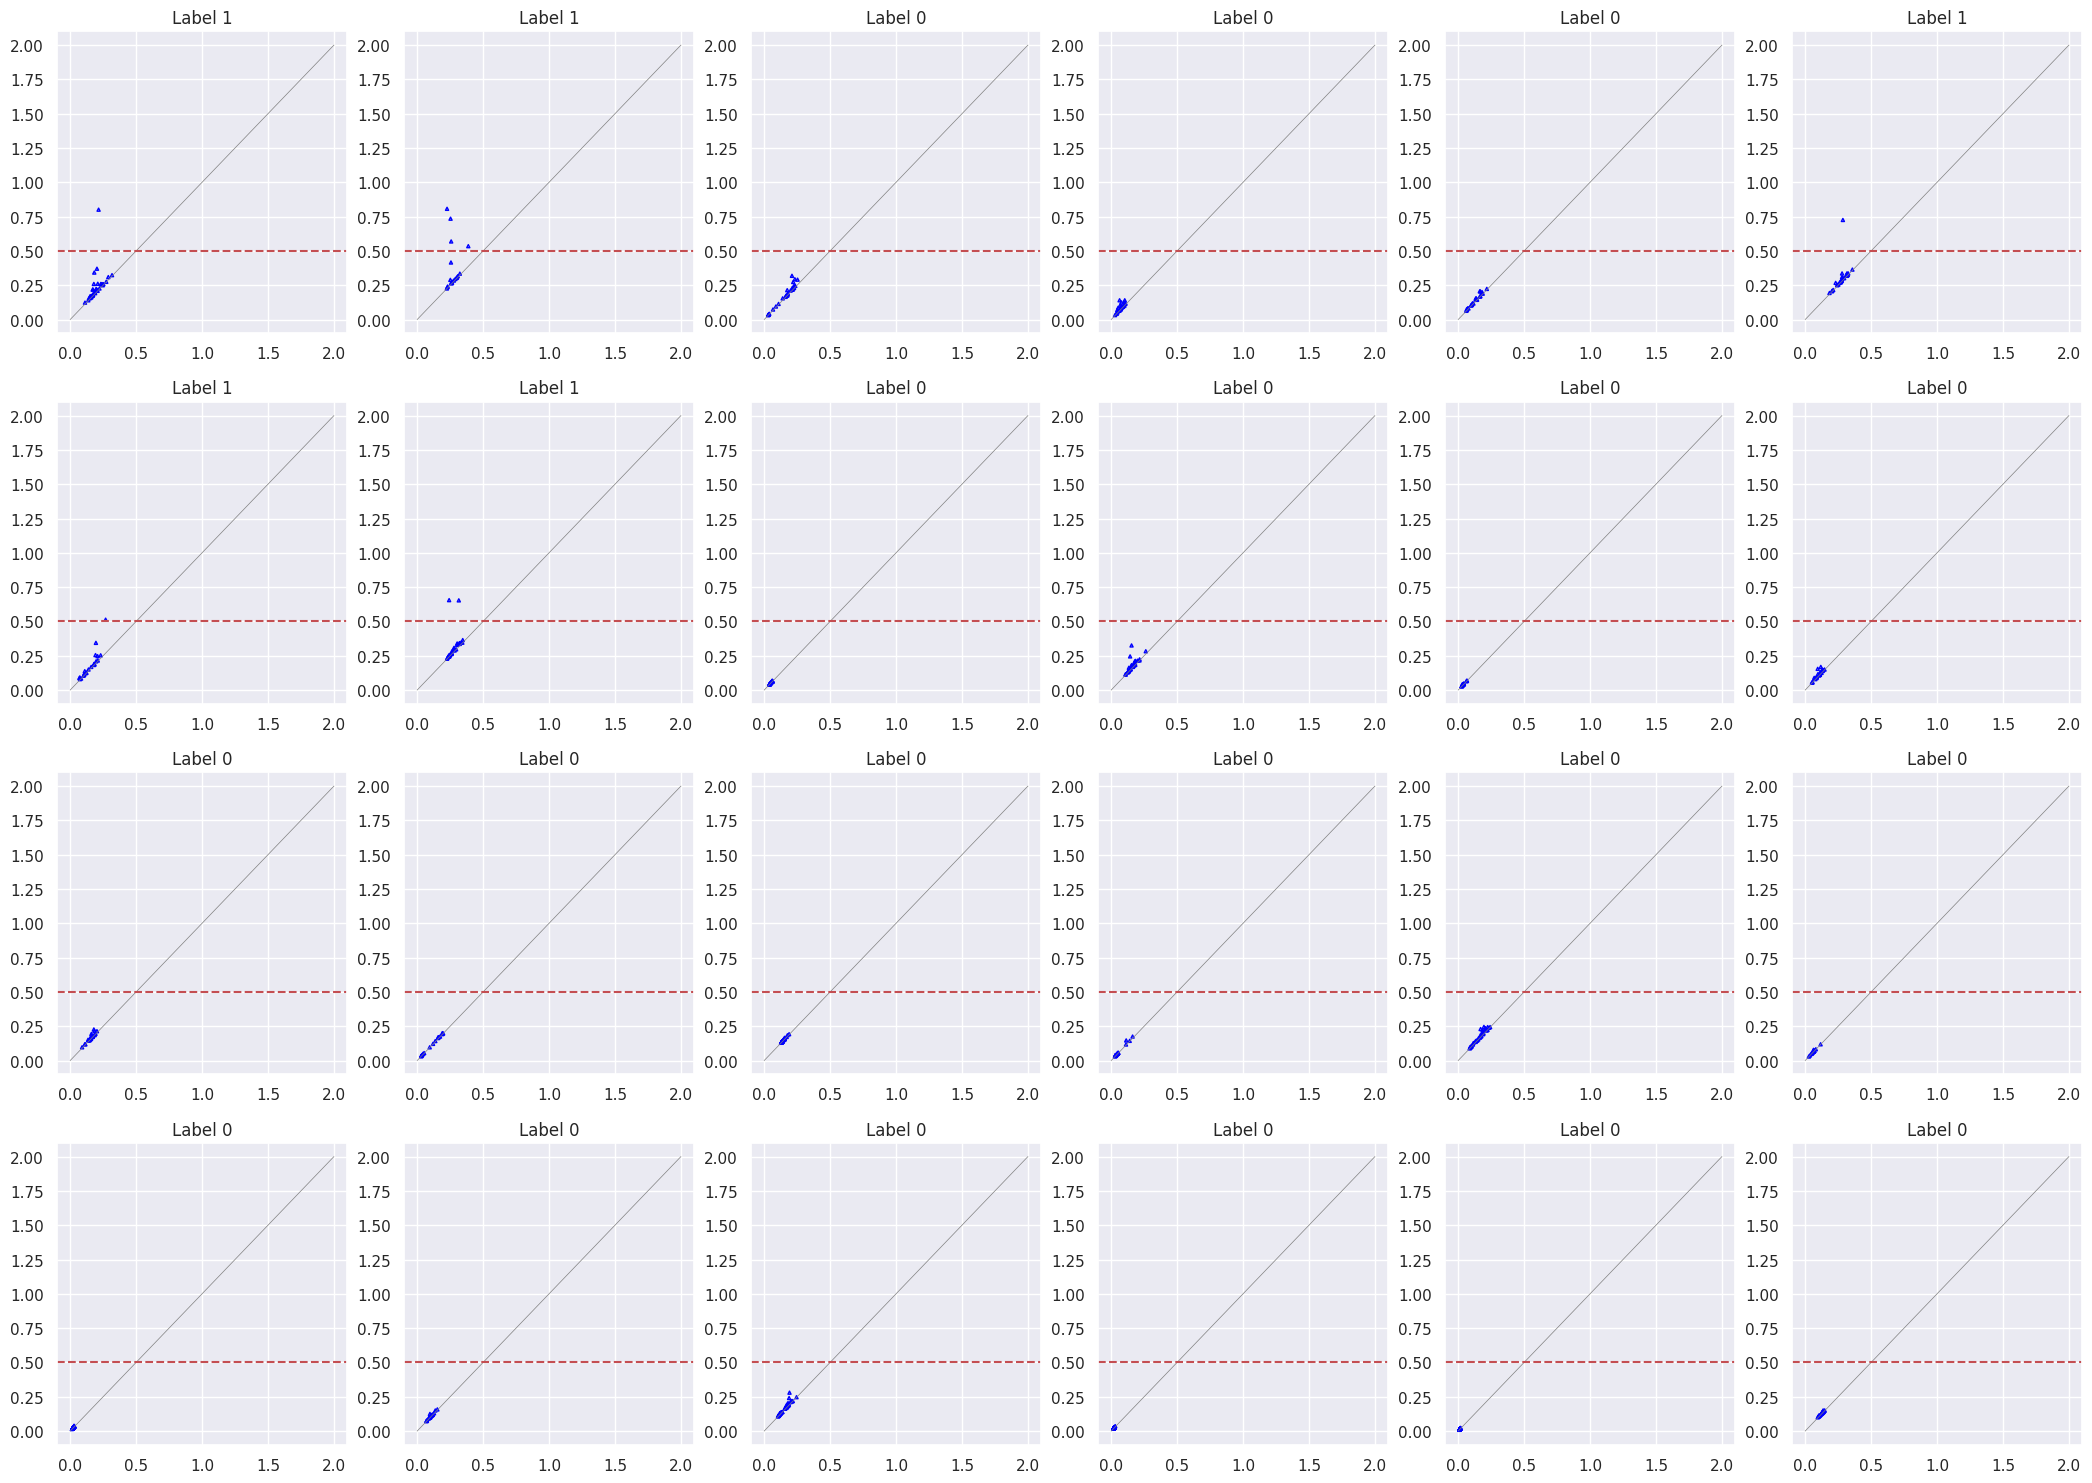

In [ ]:
fig, axs = plt.subplots(4, 6, figsize=(21, 15))

pd0_union = []
pd1_union = []
groundTruth = []
for i in range(4):
    for j in range(6):
        lower_bound = 0
        upper_bound = 3
        
        p0, p1 = extract_PD_arrays_with_freudenthal_triangulation(channel7List[i* 6 + j + 50], lower_bound = lower_bound, upper_bound = upper_bound)
        pd0_union.append(p0)
        pd1_union.append(p1)
        #axs[i, j].scatter(birth0, death0, color='r', s=5, label = 'Dimension 0')
        axs[i, j].scatter(p1[0], p1[1], marker='^', s=5, facecolors='none', edgecolor='blue', label = 'Dimension 1')
        #axs[i, j].scatter(p0[0], p0[1], marker='^', s=5, facecolors='none', edgecolor='red', label = 'Dimension 0')
        axs[i, j].plot(np.arange(lower_bound, upper_bound), np.arange(lower_bound, upper_bound), '-', color='grey', lw=0.5)
        #axs[i, j].plot(np.arange(lower_bound, upper_bound), 2, '-', color='grey', lw=0.5)
        axs[i, j].axhline(y = 0.5, color='r', linestyle='--')

        label = dfLabel.loc[dfLabel['fname'] == channel7Name[i* 6 + j + 50], 'fire'].iloc[0]
        groundTruth.append(label)
        axs[i, j].title.set_text('Label {}'.format(label))
        #axs[i, j].set_xlabel('Birth')
        #axs[i, j].set_ylabel('Death')

plt.tight_layout()
plt.show()

In [ ]:
def optimalDBSCAN(data, score_, eps, metric='euclidean', bMax=True, distType=0):
    eps_range=np.arange(eps['min'],eps['max'],eps['inc'])
    min_samples_range=range(2,10)
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
        
    eps_ask=0
    min_samples_ask=0
    clustering_ask=None
    print("score, best_score, eps, eps_ask, min_samples, min_samples_ask")
    for min_samples in min_samples_range:
     for eps in eps_range:
      clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
      clustering.fit(data)
      if len(np.unique(clustering.labels_))>1:
        if distType==0:
            score=score_(data, clustering.labels_)
        elif distType==1:
            dist=pairwise_distances(data)
            score=score_(dist, clustering.labels_)
        elif distType==2:
            dist=pairwise_distances(data)
            score=score_(data, dist, clustering.labels_)
        if (score>best_score and bMax==True):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering
        elif(score<best_score and bMax==False):
          best_score=score
          eps_ask=eps
          min_samples_ask=min_samples
          clustering_ask=clustering  
        print(score, best_score, eps, eps_ask, min_samples, min_samples_ask)
    return(best_score, eps_ask, min_samples_ask, clustering_ask)   

def optimalHClust(data, score_, metric='euclidean', bMax=True, distType=0):
    if bMax==True:
        best_score =-1e9
    else:
        best_score =1e9
    linkage_ask = ''  
    n_ask = 2
    clustering_ask = None
    print("score, best_score, i, n_ask, linkage, linkage_ask")
    for i in range(2, 7):
        for linkage in ['complete', 'average', 'single']: 
            clustering= AgglomerativeClustering(n_clusters=i, affinity=metric, linkage=linkage)
            #clustering = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            clustering.fit(data)
            if len(np.unique(clustering.labels_))>1:
                if distType==0:
                    score=score_(data, clustering.labels_)
                elif distType==1:
                    dist=pairwise_distances(data)
                    score=score_(dist, clustering.labels_)
                elif distType==2:
                    dist=pairwise_distances(data)
                    score=score_(data, dist, clustering.labels_)
                if (score>best_score and bMax==True):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i
                    clustering_ask=clustering
                elif(score<best_score and bMax==False):
                    best_score=score
                    linkage_ask=linkage
                    n_ask=i 
                    clustering_ask=clustering
                print(score, best_score, i, n_ask, linkage, linkage_ask)
    return(best_score, n_ask, linkage_ask, clustering_ask)

In [ ]:
def PD2Silhoutte(PDList, resolution = 100):
    SH = gd.representations.Silhouette(resolution=resolution, weight=lambda x: np.power(x[1]-x[0],1))
    SilList = []
    for i in range(len(PDList)):
        sh = SH.fit_transform([PDList[i]])[0]
        SilList.append(sh)
    return SilList

In [ ]:
PDList = []
for i in pd1_union:
    temp = np.vstack((i[0], i[1])).T
    PDList.append(temp)

24


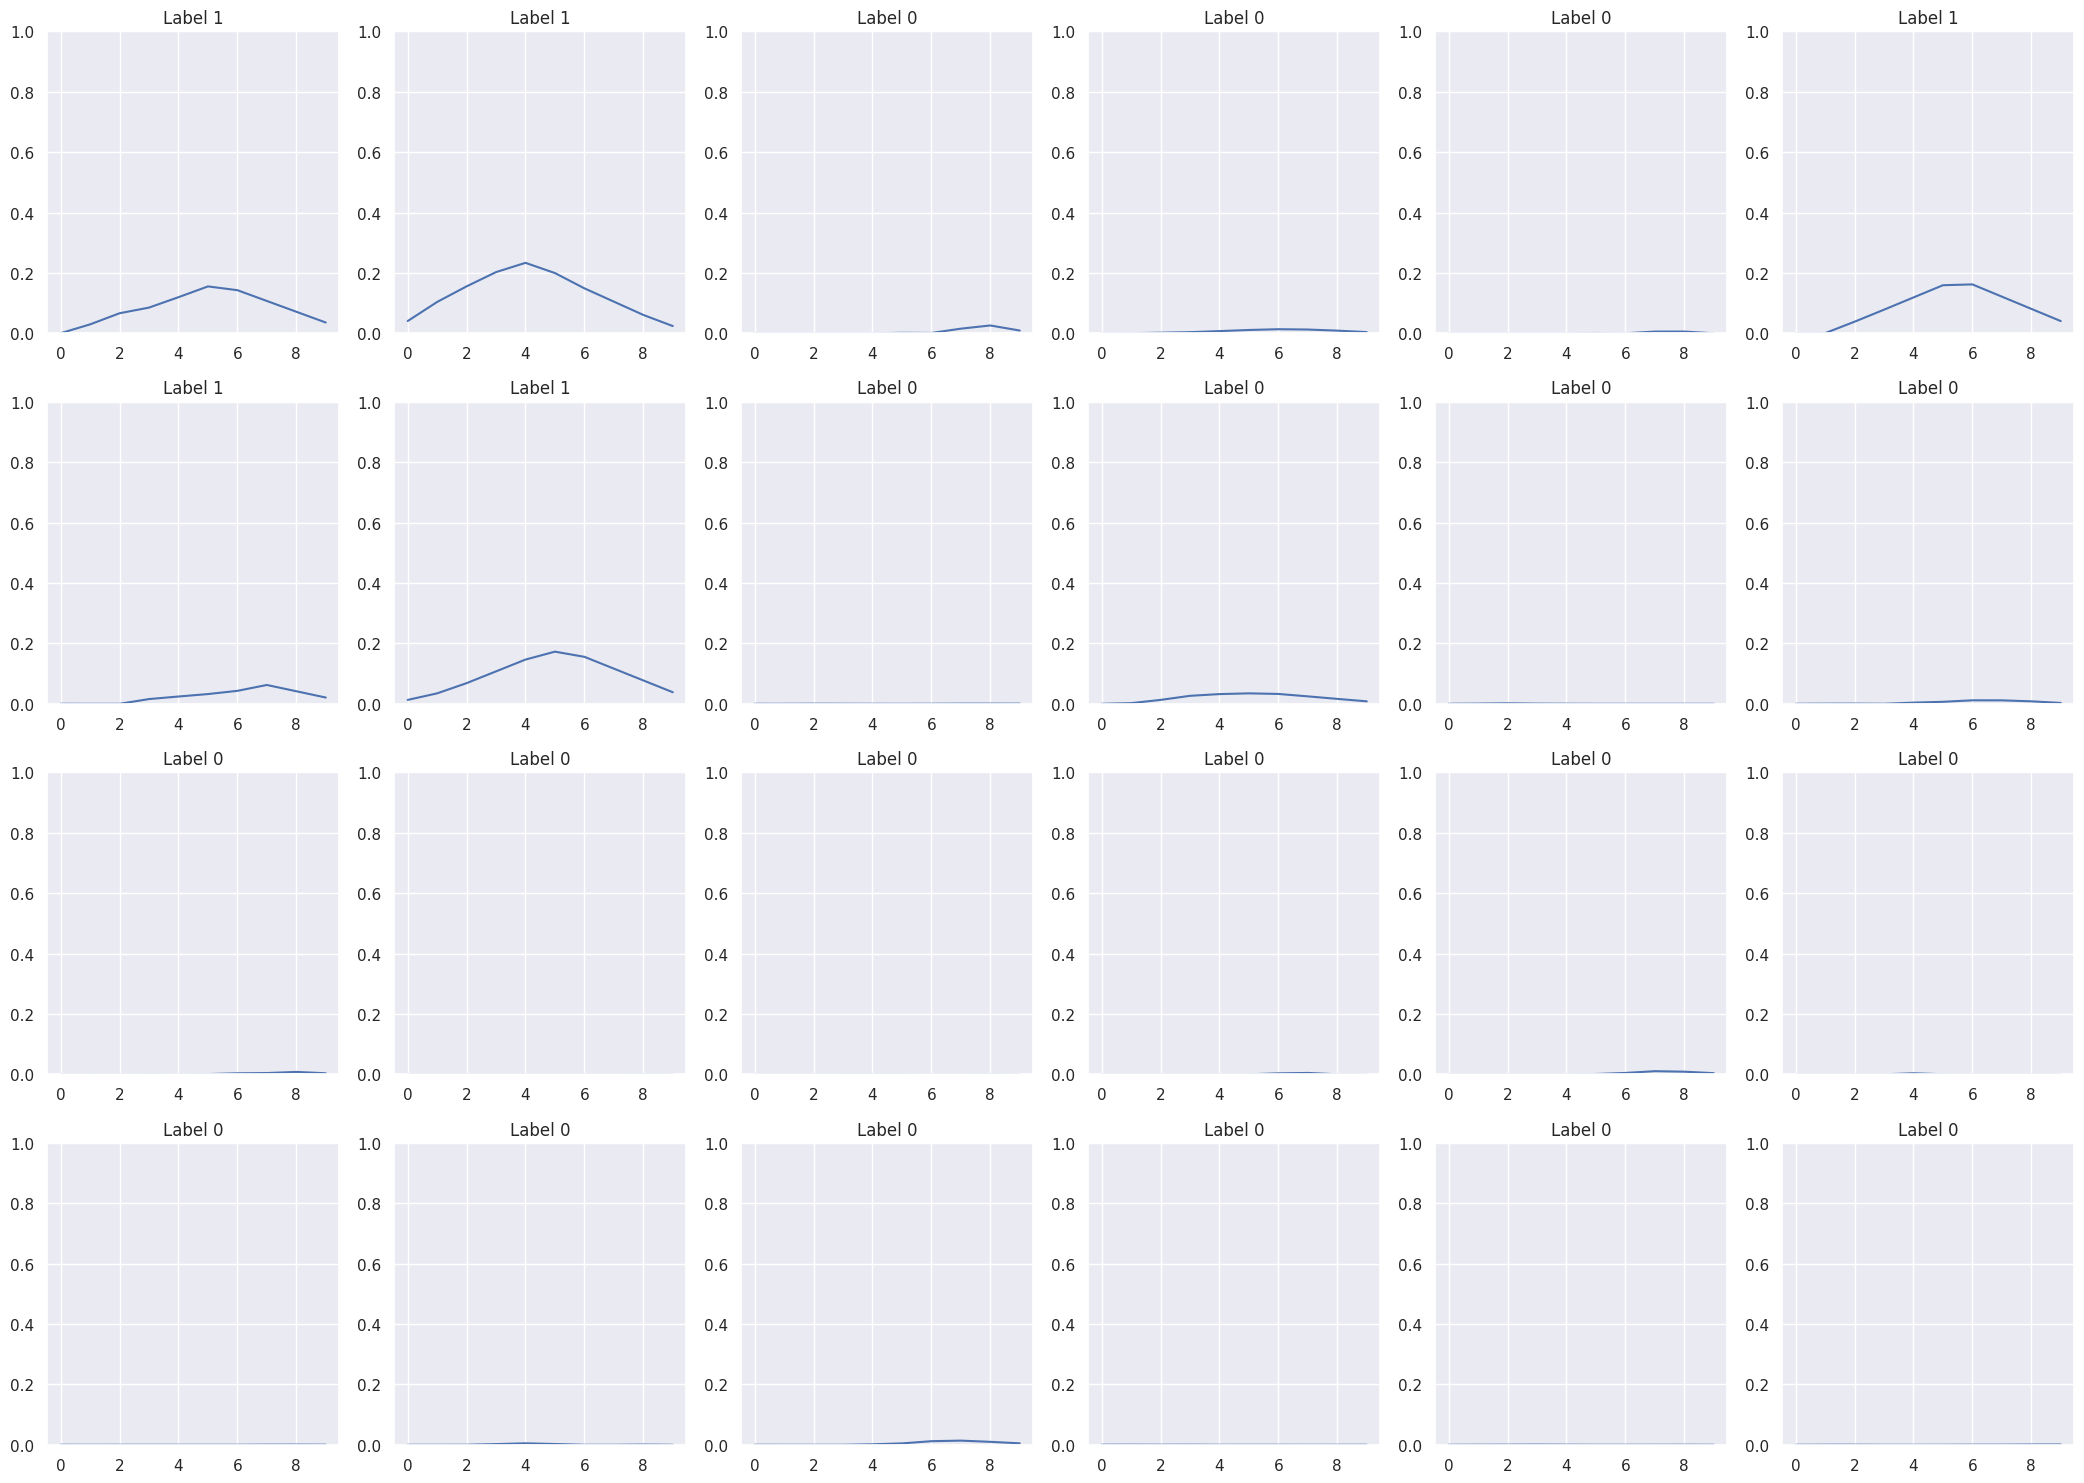

In [ ]:
# Vectorize the PDs then do cluster
# Vectorize by Silhoutte
SilList = PD2Silhoutte(PDList, resolution=10)

print (len(SilList))

# Result from R
# simplexVolDepthList = [0.9782665, 0.9598752, 0.9803188, 0.9715499, 0.979676, 0.968288, 0.954594, 0.4730382, 0.9818818, 0.6771605, 0.9807952, 0.9813164, 0.9812129, 0.9795362, 0.9805354, 0.9723188, 0.962765, 0.000]

fig, axs = plt.subplots(4, 6, figsize=(21, 15))
for i in range(4):
    for j in range(6):
        axs[i, j].plot(SilList[i*6 + j])
        axs[i, j].set_ylim(0, 1)
        
        #axs[i, j].title.set_text('Label {}, Data Depth {:.3f}'.format(groundTruth[i*6 + j], simplexVolDepthList[i*6 + j])) # Add later with data depth value
        axs[i, j].title.set_text('Label {}'.format(groundTruth[i*6 + j]))

plt.tight_layout()
plt.show()